In [1]:
# prerequisites:
# pip install -U swifter[groupby]
import swifter 
    
import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn import linear_model

In [2]:
# HYPER-PARAMETERS 
NOISE_FACTOR = 1  # кол-во шумовых фотонов по отношению к правильным
MINIMUM_FOTONS_NUMBER = 4  # Не рассматриваем случаи с меньшим чем MINIMUM_FOTONS_NUMBER числом фотонов
ROTATION_ANGLE = 0 # np.pi/4 # Угол поворота картинки (особо не влияет на обучение)
NUMBER_OF_CASES = 10000 # Кол-во случаев для обучения
BAND_WIDTH = 5 # Половина ширины полоски, в которой считаются фотоны
BAND_ROTATIONS_NUMBER = 100 # число поворотов для определения оптимального угла. минимальный угол поворота = 360гр/BAND_ROTATIONS_NUMBER 

In [3]:
df = pd.read_hdf("./data/Out_fin_pad(200)_x(-1.0,1.0)_E(0.01,10000.0)_eff(0.8)_101.h5")
df['Num'].max()

299998.0

In [4]:
# генерирует шум
def generate_uniform(df, size):
    size_df = len(df)
    xarr = uniform.rvs(scale = 199, size = size * size_df)
    yarr = uniform.rvs(scale = 199, size = size * size_df)
    return pd.DataFrame({'x_det_pad': xarr.astype(int), 'y_det_pad': yarr.astype(int)})

In [5]:
# определяет, лежит ли точка (px,py) в (верхней) полуплоскости, образуемой прямой, проходящей через (x0,y0), (x1,y1)
def point_belongs_to_semiplane(x0,y0,x1,y1,px,py):
    return np.cross([x1-x0, y1-y0], [px-x0,py-y0]) >= 0

In [6]:
# считает кол-во фотонов, попадающих в полосу шириной +-width, проходящую через точку (x0,y0) под углом alpha
def count_points_in_band(df, x0, y0, alpha, width):         
    x1 = x0 + np.cos(alpha)
    y1 = y0 + np.sin(alpha)
    
    width_x = - width * np.sin(alpha)
    width_y = width * np.cos(alpha)
       
    count = 0
    for index, row in df.iterrows():
        x = row['x_det_pad']
        y = row['y_det_pad']
        if (not point_belongs_to_semiplane(x0 + width_x, y0 + width_y,x1 + width_x, y1 + width_y, x, y) and
            point_belongs_to_semiplane(x0 - width_x, y0 - width_y,x1 - width_x, y1 - width_y, x, y) and
            not point_belongs_to_semiplane(x0 - width_x, y0 - width_y, x0 + width_x, y0 + width_y, x, y)
           ):
            count += 1
    
    return count

In [7]:
# находит оптимальный угол поворота для отдельного эксперимента путем полного перебора
def find_max_alfa(df, x0, y0, width):
    alpha_max = 0
    cmax = 0
    for alpha in np.arange(-np.pi, np.pi, 2*np.pi/BAND_ROTATIONS_NUMBER):
        c = count_points_in_band(df, x0, y0, alpha, width)
        if c > cmax:
            cmax = c
            alpha_max = alpha
            
    return alpha_max - ROTATION_ANGLE

In [8]:
# смещает и поворачивает данные отдельного эксперимента единообразным способом
def transform_data(df, width):   
    # не рассматриваем случаи с малым числом фотонов
    if len(df) < MINIMUM_FOTONS_NUMBER:
        return
    
    # находим порождающую частицу
    particle = df.query('Eg == 0')
    # не рассматриваем случаи с двумя и более частицами
    if len(particle) > 1:
        return
    
    # находим координаты этой частицы
    x0 = float(particle.iloc[0]['x_det_pad'])
    y0 = float(particle.iloc[0]['y_det_pad'])
    
    # определяем нужный угол поворота
    alpha_max = find_max_alfa(df, x0, y0, width)
    
    # для лучшего качества данных для обучения модели шум добавляем уже после определени угла поворота
    noise = generate_uniform(df, NOISE_FACTOR)
    df_and_noise = pd.concat([df, noise])
        
    # смещаем и поворачиваем точки
    XY = df_and_noise[['x_det_pad','y_det_pad']] - [x0,y0]
    # матрица поворота
    R = np.transpose([
        [np.cos(alpha_max), np.sin(alpha_max)],
        [-np.sin(alpha_max),np.cos(alpha_max)]
    ])      
    df_and_noise[['x_det_pad', 'y_det_pad']] = np.matmul(XY,R)
       
    return (df_and_noise)

In [9]:
def plot_elements(df, low=0, up=200):
    fig, ax = plt.subplots(figsize=(5,5))
  
    plt.xlim(low,up)
    plt.ylim(low,up)
    particle = df.query('Eg == 0')
    df = df.drop(df[df.Eg == 0].index)
    
    data = df[df.Num.notnull()]
    noise = df[df.Num.isna()]
    
    ax.scatter(data[['x_det_pad']], data[['y_det_pad']], s=2)
    ax.scatter(noise[['x_det_pad']], noise[['y_det_pad']], s=1, facecolor='green')
    ax.scatter(particle[['x_det_pad']], particle[['y_det_pad']], facecolor='red', s=2)
    return fig, ax

In [10]:
# группируем данные по номеру эксперимента, для каждой группы запускаем трансформацию данных
rotated = df.query('Num < @NUMBER_OF_CASES').swifter.groupby("Num").apply(lambda x: transform_data(x, BAND_WIDTH))

  0%|          | 0/24 [00:00<?, ?it/s]

2023-12-10 17:40:24,459	INFO worker.py:1673 -- Started a local Ray instance.


(<Figure size 500x500 with 1 Axes>, <Axes: >)

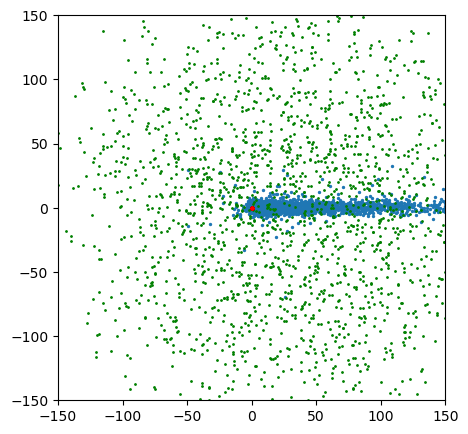

In [11]:
#plot_elements(df.query('Num == 122'))
# рисуем первые 4000 строчек датасета
plot_elements(rotated.head(4000), -150, 150)

In [12]:
# удаляем порождающие частицы из датасета
rotated = rotated.drop(rotated[rotated.Eg == 0].index)

In [13]:
# преобразуем датасет в массив классов: 0 - шумовой фотон, 1 - "правильный" фотон
# для шума колонка Num содержит значения NaN
y = rotated['Num'].apply(lambda x: 0 if np.isnan(x) else 1).transpose().to_numpy()

In [14]:
# преобразуем датасет в массив с координатами точек
X = rotated[['x_det_pad','y_det_pad']].to_numpy()

In [15]:
# выводим размерность массивов
print(X.shape)
print(y.shape)

(81778, 2)
(81778,)


In [16]:
#========================================================================================
# CLASSIFIER TRAINING
#========================================================================================
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import pickle

In [17]:

datasets = [
    (X, y)
]
names = [
    #"Poly SVM",
    "RBF SVM"
]

# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py
classifiers = [
    #SVC(kernel="poly", C=1, degree=2, random_state=42),   
    SVC(gamma=2, C=1, random_state=42, cache_size= 1000)
]

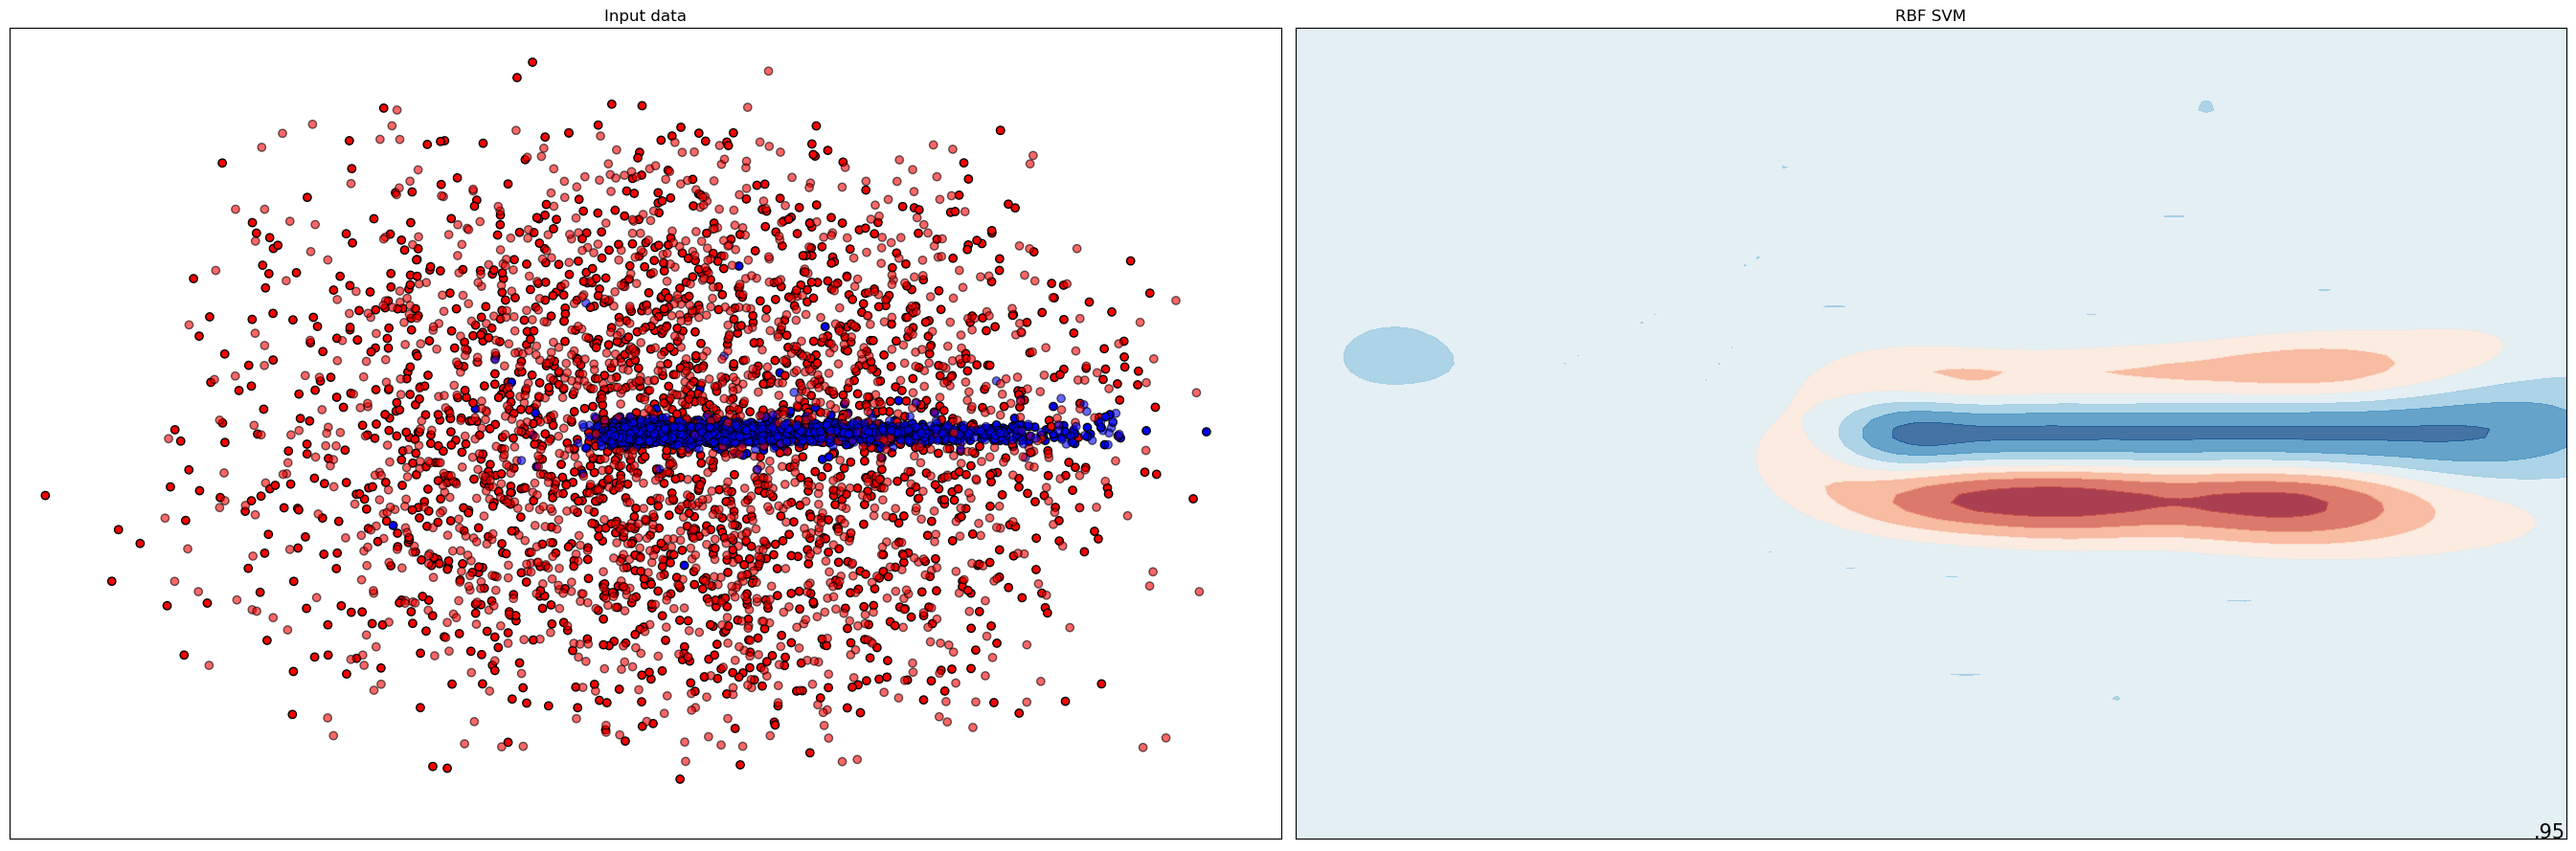

In [18]:
DRAW_LIMIT = 3000
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:DRAW_LIMIT, 0], X_train[:DRAW_LIMIT, 1], c=y_train[:DRAW_LIMIT], cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:DRAW_LIMIT, 0], X_test[:DRAW_LIMIT, 1], c=y_test[:DRAW_LIMIT], cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)

        # save model
        pickle.dump(clf, open(name + ".model", "wb"))
        # load model
        #loaded_model = pickle.load(open(filename, "rb"))
        
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        '''ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )'''

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [19]:
svm = pickle.load(open("RBF SVM.model", "rb"))

In [20]:
svm.predict([[0,0],[1,1],[45,45]])

array([1, 1, 0], dtype=int64)

In [21]:
import ray
ray.shutdown()